In [1]:
from openai import OpenAI
from pathlib import Path
import fitz  # PyMuPDF
import pandas as pd
from tqdm import tqdm
import json
from dotenv import load_dotenv

from pdf2image import convert_from_path
import pytesseract
from PIL import Image
import tempfile
import os

import base64
import shutil

from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor



In [2]:
# =========================
# Init
# =========================
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

PDF_DIR = Path("pdf_folder")  # Ensure this path contains your PDFs

# ==== TOKENS: helper
def _tokens_of(response):
    """Safely get tokens from OpenAI response. Returns (prompt, completion, total)."""
    try:
        u = response.usage
        pt = getattr(u, "prompt_tokens", 0) or 0
        ct = getattr(u, "completion_tokens", 0) or 0
        return pt, ct, pt + ct
    except Exception:
        return 0, 0, 0
    
    

In [3]:

# OCR 补救函数：用于从首页和末页图像提取文本

def extract_text_with_ocr(pdf_path, front_n=5, back_n=5, dpi=300):
    from pdf2image.exceptions import PDFPageCountError
    try:
        with tempfile.TemporaryDirectory() as path:
            try:
                images = convert_from_path(str(pdf_path), dpi=dpi, output_folder=path)
            except PDFPageCountError as e:
                return f"OCR ERROR: PDF structure invalid – {str(e)}"
            except Exception as e:
                return f"OCR ERROR: {str(e)}"

            total_pages = len(images)
            if total_pages == 0:
                return "OCR ERROR: No images extracted"

            selected = images[:front_n] + images[-back_n:]
            texts = []
            for img in selected:
                img = img.convert("L")  # 灰度增强
                text = pytesseract.image_to_string(img, lang="eng")
                texts.append(text)
            return "\n".join(texts)
    except Exception as e:
        return f"OCR ERROR (outer): {str(e)}"
    


In [4]:

def extract_front_back_text(pdf_path, front_n=10, back_n=10, dpi=300):
    try:
        doc = fitz.open(str(pdf_path))
        texts = []
        for i in range(min(front_n, len(doc))):
            texts.append(doc[i].get_text())
        for i in range(max(0, len(doc) - back_n), len(doc)):
            texts.append(doc[i].get_text())
        doc.close()
        full_text = "\n".join(texts)
        if len(full_text.strip()) < 100:
            raise ValueError("Too short, fallback to OCR.")
        return full_text
    except Exception as e:
        print(f"⚠️ Fallback to OCR on: {pdf_path.name} due to {str(e)}")
        return extract_text_with_ocr(pdf_path, front_n, back_n, dpi)



In [5]:


# =========================
# Task 1: classify (gpt-4.1-mini)
# =========================

def classify_report_type(text):
    system_prompt = "You are an expert in classification."
    user_prompt =f"""
The following text is extracted from a corporate report (first and last few pages).

Your tasks:

1. Classify the report into one of the following types:
- "sustainability report": The document primarily focuses on ESG, sustainability, CSR, or GRI/SDGs-related topics. It does NOT contain full audited financial statements.
- "annual report": The document primarily contains audited financial disclosures, such as income statements, cash flow statements, balance sheets, and auditor's reports. ESG content, if any, is limited or supplementary.
- "integrated report": The document includes BOTH complete financial disclosures and structured sustainability content within the same document.
- "other": The document does not meet the criteria for any of the above (e.g., regulatory compliance reports, environmental approvals, investor brochures, etc.)

2. Important judgment rules:
- Do NOT classify a "Corporate Social Responsibility Report", "Corporate Responsibility Report", or "CSR Report" as "integrated report" unless it also includes full audited financials.
- If the title contains "Annual Report" but the content lacks actual financial statements, do NOT classify it as "annual" or "integrated".
- References or summaries of financials are NOT sufficient — only classify based on complete financial statement inclusion.

3. If the document contains a distinct sustainability section (e.g. a chapter on ESG/CSR/GRI/SDGs content that constitutes more than 50% of a section), mark `has_sustainability_section = true`, and extract the section name if available.

Return a JSON object with the following fields:
{{
  "reasoning": "...",
  "report_type": "...",
  "has_sustainability_section": true/false,
  "sustainability_section_name": "..."
}}

Content:
{text}
"""
    
    try:
        response = client.chat.completions.create(
            model="gpt-4.1",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0
        )
        reply = response.choices[0].message.content
        parsed = json.loads(reply)

        # ==== TOKENS
        _, _, total_tokens = _tokens_of(response)

        return (
            parsed.get("report_type", ""),
            parsed.get("has_sustainability_section", ""),
            parsed.get("sustainability_section_name", ""),
            parsed.get("reasoning", ""),
            {"gpt-4.1": total_tokens}  # tokens per model for this task
        )
    except Exception as e:
        return "ERROR", False, "", f"Exception: {e}", {"gpt-4.1": 0}



In [6]:

# =========================
# Task 2: year (gpt-4.1-mini primary; fallback gpt-4o vision)
# =========================
def build_report_year_prompt(text):
    return f"""
You are an expert assistant helping to extract reporting years from corporate reports.

Please complete the following tasks after carefully reading the text below:

---

### Task 1: Identify any **fiscal year**, **reporting period**, or **financial year** expressions.

Common examples include:
- "for the year ended 31 December 2021"
- "reporting period: April 2021 – March 2022"
- "2011–14" or "FY2017"
- "2020 ESG highlights"
- "2013 Corporate Report"

---

### Task 2: Normalize each valid expression into a standardized format:

1. If the expression is a **single year**, like `"2013"` or `"FY2020"`, output `"2013"` or `"2020"` as-is.
2. If it is a **range of years only**, like `"2014–15"`, output `"2014 to 2015"`. Do **not** add months or days.
3. If full dates are mentioned (e.g., `"1st April 2020 – 31st March 2021"`), remove ordinal suffixes (`1st`, `2nd`, etc.) and format as:
   `"1 April 2020 to 31 March 2021"`
4. Always convert dashes ("–" or "-") to "to".
5. If month is provided but not day (e.g., `"April 2020 – March 2021"`), convert to `"April 2020 to March 2021"`.

---

### Task 3: Return a JSON in the following format:

If a valid reporting year expression is found:

{{
  "normalized_report_year": "your normalized result here",
  "original_expression": "copy the original matched expression",
  "source": "e.g. Page 1, main text"
}}

If no valid expression is found:

{{
  "normalized_report_year": null,
  "original_expression": null,
  "source": "NOT FOUND"
}}

Only output the JSON object. Do not add explanations or commentary.

---

Text:
{text}
"""


def encode_image_to_base64(pil_image):
    with tempfile.NamedTemporaryFile(suffix=".png") as f:
        pil_image.save(f.name, format="PNG")
        with open(f.name, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")

def extract_year_from_vision(pdf_path, page_limit=5):
    # ==== TOKENS
    tokens_by_model = {"gpt-4o": 0}

    try:
        images = convert_from_path(pdf_path, dpi=200)
        for i, img in enumerate(images[:page_limit]):
            b64 = encode_image_to_base64(img)
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "user", "content": [
                        {"type": "text", "text": f"Please extract the fiscal year or reporting period from page {i+1}. Please return in this JSON format:\n"
                                                 "{\n  \"normalized_report_year\": \"...\",\n  \"original_expression\": \"...\",\n  \"source\": \"Page {i+1}, image-based\"\n}"},
                        {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{b64}"}}
                    ]}
                ],
                max_tokens=300
            )
            # ==== TOKENS
            _, _, tk = _tokens_of(response)
            tokens_by_model["gpt-4o"] += tk

            content = response.choices[0].message.content
            parsed = json.loads(content.strip()) if content.strip().startswith("{") else eval(content.strip())
            if parsed.get("normalized_report_year"):
                parsed["tokens_by_model"] = tokens_by_model  # ==== TOKENS
                return parsed
    except Exception as e:
        return {
            "normalized_report_year": None,
            "original_expression": None,
            "source": f"Vision ERROR: {e}",
            "tokens_by_model": tokens_by_model  # ==== TOKENS
        }
    return {
        "normalized_report_year": None,
        "original_expression": None,
        "source": "Vision NOT FOUND",
        "tokens_by_model": tokens_by_model  # ==== TOKENS
    }

def extract_report_year(pdf_path):
    # ==== TOKENS
    tokens_by_model = {"gpt-4.1": 0, "gpt-4o": 0}

    try:
        text = extract_front_back_text(pdf_path)
        prompt = build_report_year_prompt(text)
        response = client.chat.completions.create(
            model="gpt-4.1",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
            # max_tokens=500
        )
        # ==== TOKENS
        _, _, tk = _tokens_of(response)
        tokens_by_model["gpt-4.1"] += tk

        content = response.choices[0].message.content
        parsed = json.loads(content.strip()) if content.strip().startswith("{") else eval(content.strip())
        if parsed.get("normalized_report_year"):
            parsed["tokens_by_model"] = tokens_by_model  # ==== TOKENS
            return parsed
    except Exception as e:
        print(f"⚠️ GPT-4.1 failed on {Path(pdf_path).name}, fallback to Vision...")

    parsed = extract_year_from_vision(pdf_path)
    # 合并 vision 的 tokens
    for k, v in parsed.get("tokens_by_model", {}).items():
        tokens_by_model[k] = tokens_by_model.get(k, 0) + v
    parsed["tokens_by_model"] = tokens_by_model  # ==== TOKENS
    return parsed


In [7]:

# =========================
# Task 3: company/publisher (gpt-4.1 primary, optional 2nd call)
# =========================
def extract_company_or_publisher_with_gpt(text):
    import json
    total_by_model = {"gpt-4.1": 0}  # ==== TOKENS
    primary_prompt = f"""
You are a corporate reporting analyst.

From the first and last pages of a corporate report, extract the following:
1. The **official company name** that issued the report.
2. A list of **other names** referring to the company (abbreviations, group name, acronyms, etc.).
3. The **country** where the company is headquartered.
4. A brief **reasoning** explaining your extraction.

Return a JSON object like this:
{{
  "company_name": "...",
  "other_names": ["...", "..."],
  "country": "...",
  "reasoning": "..."
}}

If the company name is not found, return:
{{
  "company_name": "UNKNOWN",
  "other_names": [],
  "country": "UNKNOWN",
  "reasoning": "No indication of the company in the text."
}}

Text:
{text}
"""
    try:
        response = client.chat.completions.create(
            model="gpt-4.1",
            messages=[
                {"role": "system", "content": "You are an expert in ESG and corporate reporting."},
                {"role": "user", "content": primary_prompt}
            ],
            temperature=0
        )
        # ==== TOKENS
        _, _, tk = _tokens_of(response)
        total_by_model["gpt-4.1"] += tk

        content = response.choices[0].message.content.strip()
        result = json.loads(content)
    except Exception as e:
        return {
            "company_name": "GPT_ERROR",
            "other_names": [],
            "country": "GPT_ERROR",
            "reasoning": str(e),
            "publisher": None,
            "tokens_by_model": total_by_model  # ==== TOKENS
        }
    except json.JSONDecodeError:
        return {
            "company_name": "PARSE_ERROR",
            "other_names": [],
            "country": "PARSE_ERROR",
            "reasoning": f"Raw response: {content}",
            "publisher": None,
            "tokens_by_model": total_by_model  # ==== TOKENS
        }

    # 第二阶段：若无法识别公司名，尝试提取 publisher
    if result.get("company_name", "").upper() == "UNKNOWN":
        try:
            secondary_prompt = f"""
This report was not issued by a company but possibly by a public institution or academic body.

From the following text, extract the **publisher** and return:
{{ "publisher": "..." }}

If not found:
{{ "publisher": "UNKNOWN" }}

Text:
{text}
"""
            response2 = client.chat.completions.create(
                model="gpt-4.1",
                messages=[
                    {"role": "system", "content": "You are an expert in institutional publishing."},
                    {"role": "user", "content": secondary_prompt}
                ],
                temperature=0
            )
            # ==== TOKENS
            _, _, tk2 = _tokens_of(response2)
            total_by_model["gpt-4.1"] += tk2

            content2 = response2.choices[0].message.content.strip()
            pub_result = json.loads(content2)
            result["publisher"] = pub_result.get("publisher", "UNKNOWN")
        except Exception as e:
            result["publisher"] = f"GPT_ERROR: {str(e)}"
    else:
        result["publisher"] = None

    # 清理字段
    if result.get("company_name", "").upper() == "UNKNOWN":
        result["company_name"] = ""
    if not isinstance(result.get("other_names"), list):
        result["other_names"] = []
    if "country" not in result or not isinstance(result["country"], str):
        result["country"] = "UNKNOWN"

    # ==== TOKENS
    result["tokens_by_model"] = total_by_model
    return result


In [8]:

# =========================
# Pipeline per PDF
# =========================
def process_pdf(pdf_path):
    text = extract_front_back_text(pdf_path)

    # Task 1: classify
    report_type, sustainability, sustainability_name, classify_reasoning, tk_classify_by_model = classify_report_type(text)

    # Task 2: year
    year = extract_report_year(pdf_path)
    tk_year_by_model = year.get("tokens_by_model", {})

    # Task 3: company
    company = extract_company_or_publisher_with_gpt(text)
    tk_company_by_model = company.get("tokens_by_model", {})

    # ==== TOKENS: aggregate per model
    tokens_by_model = {}
    for d in (tk_classify_by_model, tk_year_by_model, tk_company_by_model):
        for m, t in d.items():
            tokens_by_model[m] = tokens_by_model.get(m, 0) + (t or 0)

    # Subtask tokens (for readability per row)
    tokens_classify = sum(tk_classify_by_model.values())
    tokens_year = sum(tk_year_by_model.values())
    tokens_company = sum(tk_company_by_model.values())
    tokens_total = tokens_classify + tokens_year + tokens_company

    return {
        "filename": pdf_path.name,
        "report_type": report_type,
        "has_sustainability_section": sustainability,
        "sustainability_section_name": sustainability_name,
        "classify_reasoning": classify_reasoning,

        "normalized_report_year": year.get("normalized_report_year"),
        "original_expression": year.get("original_expression"),
        "year_source": year.get("source"),

        "company_name": company.get("company_name"),
        "other_names": "; ".join(company.get("other_names", [])),
        "publisher": company.get("publisher"),
        "country": company.get("country"),
        "reasoning": company.get("reasoning"),

        # ==== TOKENS: per subtask
        "tokens_classify": tokens_classify,
        "tokens_year": tokens_year,
        "tokens_company": tokens_company,
        "tokens_total": tokens_total,

        # ==== TOKENS: per model (columns for convenience)
        "tokens_gpt4_1_mini": tokens_by_model.get("gpt-4.1-mini", 0),
        "tokens_gpt4_1": tokens_by_model.get("gpt-4.1", 0),
        "tokens_gpt4o": tokens_by_model.get("gpt-4o", 0),
    }


In [ ]:

# =========================
# Run
# =========================
pdf_dir = Path("pdf_folder")
output_path = Path("results/pipeline7-gpt.csv")
os.makedirs(output_path.parent, exist_ok=True)

pdf_files = list(pdf_dir.glob("*.pdf"))
MAX_WORKERS = 5

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    results = list(tqdm(executor.map(process_pdf, pdf_files), total=len(pdf_files), desc="🚀 Processing PDFs"))

df = pd.DataFrame(results)
df.to_csv(output_path, index=False)
print(f"✅ Done! Results saved to: {output_path}")

🚀 Processing PDFs:   1%|          | 9/1278 [00:43<1:03:17,  2.99s/it]

⚠️ GPT-4.1 failed on Unknown_2022053120034016302_1gl1sbq2.pdf, fallback to Vision...


🚀 Processing PDFs:   3%|▎         | 32/1278 [02:55<1:37:24,  4.69s/it]

⚠️ GPT-4.1 failed on GL_Ltd_kilroy-realty-corporation-sustainability-report-2018_cnh296bj.pdf, fallback to Vision...


🚀 Processing PDFs:   8%|▊         | 106/1278 [11:37<1:57:25,  6.01s/it]

⚠️ GPT-4.1 failed on LB_Group_Co_Ltd_NORDLB_Group_Annual_Report_2016_b5ytf1lb.pdf, fallback to Vision...


🚀 Processing PDFs:  10%|▉         | 124/1278 [13:08<1:21:05,  4.22s/it]

⚠️ GPT-4.1 failed on Colgate-Palmolive_Co_sustainability-report-colgate-palmolive-2016_2djnidr3.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Unknown_20220412_212602_CHZ_CM2LGLZYGUI1GV3K1_ku3v3l5f.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on DCM_Shriram_Ltd_Annual20Report-20222320FINAL_compressed_9j206fdq.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Unknown_2021-03-12_standing_up_for_a_sustainable_world_creative_commons_sc7o9kix.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on IGM_Financial_Inc_CorporateResponsibilityReport_IGMFinancialInc_EN_yzfzihgo.pdf, fallback to Vision...


🚀 Processing PDFs:  11%|█         | 137/1278 [15:40<2:31:21,  7.96s/it]

⚠️ GPT-4.1 failed on Ab_Inbev_Si_Limited_AB20InBev_202220ESG20Report_FINAL_ncbtav56.pdf, fallback to Vision...


🚀 Processing PDFs:  11%|█         | 140/1278 [15:55<2:06:22,  6.66s/it]

⚠️ GPT-4.1 failed on McCormick__Co_Inc_3947ee70-7cb8-4ed3-83c3-1a80a96f2f00_pkwn253h.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Gentherm_Inc_ESG20Statement_lfonvnuc.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Arbonia_AG_afg_2011_geschaeftsbericht_en_zkpyg1uu.pdf, fallback to Vision...


🚀 Processing PDFs:  11%|█         | 141/1278 [16:19<2:58:19,  9.41s/it]

⚠️ GPT-4.1 failed on Metro_Holdings_Ltd_OTC_MTAGF_2012_lfvzdjwm.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Global_Blue_France_canon-sus-2022-e_5bthbb8l.pdf, fallback to Vision...


🚀 Processing PDFs:  11%|█         | 142/1278 [16:50<4:14:08, 13.42s/it]

⚠️ GPT-4.1 failed on CF_Industries_Holdings_Inc_ar2011_4ocuzeva.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Manappuram_Finance_Ltd_annual_report_14_15_xljehnr9.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on LICT_Corp_LICT_2020_Annual_Report_o9kixm47.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Kingfisher_PLC_annual_report_2010pdfdownloadasset_4fchki1m.pdf, fallback to Vision...


🚀 Processing PDFs:  11%|█▏        | 144/1278 [17:56<6:20:16, 20.12s/it]

⚠️ GPT-4.1 failed on Unknown_2936_CSR_Booklet_ONLINE_EN_3ynxs1dr.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Alten_Boulogne-Billancourt_2010-Registration-document-Alten_7c48n7de.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on KeyCorp_2018-CR-report_052019_drvv30t9.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Electrocomponents_PLC_LSE_ECM_2012_hu1iicx6.pdf, fallback to Vision...


🚀 Processing PDFs:  12%|█▏        | 152/1278 [18:48<3:30:03, 11.19s/it]

⚠️ GPT-4.1 failed on Sanlam_Ltd_Sanlam-ClimateWise-Report-2020_wbb9x2n9.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Storebrand_ASA_2004-annual-report-storebrand-asa_6kpfstkf.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on SLM_Solutions_Group_AG_Environmental_Report_21_0201_i63v534u.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Unknown_23-06-06_Immobilienmarktbericht_2023_EN_BF_dbncbtav.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Unknown_AAU_Campus_Climate_Survey_12_14_15_q0lmc6ay.pdf, fallback to Vision...


🚀 Processing PDFs:  12%|█▏        | 157/1278 [19:23<2:32:55,  8.18s/it]

⚠️ GPT-4.1 failed on Unknown_2020_environment_report_rvy6a7jg.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Doosan_Corp_05805f9a-db52-4e3a-8957-4b857806d1e3_6uemn179.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Edwards_Lifesciences_Corp_2011report_prxi68xg.pdf, fallback to Vision...


🚀 Processing PDFs:  12%|█▏        | 158/1278 [19:45<3:28:58, 11.19s/it]

⚠️ GPT-4.1 failed on Unknown_379534_q6j2tny0.pdf, fallback to Vision...


🚀 Processing PDFs:  13%|█▎        | 160/1278 [20:01<3:03:03,  9.82s/it]

⚠️ GPT-4.1 failed on Alexander__Baldwin_Inc_AB_Corporate-Responsibility-Report-Aug-2021_Final_0u5ay38z.pdf, fallback to Vision...


🚀 Processing PDFs:  13%|█▎        | 161/1278 [20:12<3:09:34, 10.18s/it]

⚠️ GPT-4.1 failed on Salmar_ASA_salmar-asa_2014_v63hkr0k.pdf, fallback to Vision...


🚀 Processing PDFs:  13%|█▎        | 162/1278 [20:34<4:01:17, 12.97s/it]

⚠️ GPT-4.1 failed on Gail_India_Ltd_Annual_Report_2017_18_7jyea72d.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Bollore_SE_1603124_bollore_rse_gb_2015_mel-21062016_glmflqfk.pdf, fallback to Vision...


🚀 Processing PDFs:  13%|█▎        | 164/1278 [20:48<3:15:10, 10.51s/it]

⚠️ GPT-4.1 failed on Unknown_35841919_qtv4q0pe.pdf, fallback to Vision...


🚀 Processing PDFs:  13%|█▎        | 165/1278 [21:05<3:41:25, 11.94s/it]

⚠️ GPT-4.1 failed on DMG_Mori_Co_Ltd_dmg-mori-seiki-ag_2017_et28yf7l.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on PT_Indocement_Tunggal_Prakarsa__TBK_2012-Laporan20Tahunan_t3b5ytf1.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Unknown_2015e_all_yoox8j0o.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Alibaba_Pictures_Group_Ltd_E99984E4BBB6E4BA8C-2019-20-annual-report_ebl1b3cl.pdf, fallback to Vision...


🚀 Processing PDFs:  13%|█▎        | 169/1278 [22:18<4:11:57, 13.63s/it]

⚠️ GPT-4.1 failed on Nissin_Foods_Co_Ltd_nr_2022_8byy188r.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Hill-Rom_Holdings_Inc_Corporate20Social20Investment20Report20FINAL_32202020APR48901_4c1rv2q8.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Cranswick_PLC_LSE_CWK_2018_36f6uql9.pdf, fallback to Vision...


🚀 Processing PDFs:  13%|█▎        | 170/1278 [22:47<5:08:37, 16.71s/it]

⚠️ GPT-4.1 failed on Diebold_Nixdorf_Inc_99-nfb-en-dn-ag-2018-incl-limited-assurance-report-kpmg_gd0ehiwo.pdf, fallback to Vision...


🚀 Processing PDFs:  14%|█▎        | 174/1278 [23:06<3:04:50, 10.05s/it]

⚠️ GPT-4.1 failed on Nankai_Tatsumura_Construction_Co_Ltd_kankyo2021_eng_p97kq953.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on TechnipFMC_plc_2014-reference-document-annual-report-id97_iqz13s19.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Unknown_2021032500821_uukj8xtv.pdf, fallback to Vision...


🚀 Processing PDFs:  14%|█▎        | 175/1278 [23:28<3:48:51, 12.45s/it]

⚠️ GPT-4.1 failed on Unknown_201603155521-1_0fo3aveg.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Kirkland_Lake_Gold_Ltd_Stawell_2016_yo0792x1.pdf, fallback to Vision...


🚀 Processing PDFs:  14%|█▍        | 179/1278 [24:17<3:24:27, 11.16s/it]

⚠️ GPT-4.1 failed on Majesco_NYSE_MJCO_2019_nymj6mmx.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Unknown_2021_annual_report_agrll1p8.pdf, fallback to Vision...


🚀 Processing PDFs:  14%|█▍        | 180/1278 [24:37<4:01:08, 13.18s/it]

⚠️ GPT-4.1 failed on Duni_AB_duni-ab_2018_aosffly1.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Sky_PLC_annual-report-spreads-2015_52ipwujn.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Suzlon_Energy_Ltd_12_13AnnualReport1011_4nllsl2q.pdf, fallback to Vision...


🚀 Processing PDFs:  14%|█▍        | 184/1278 [25:26<3:59:08, 13.12s/it]

⚠️ GPT-4.1 failed on Suntory_Beverage_Service_Limited_suntory_EN_2022_axj6ubbn.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Unknown_1210047282_qufbc03n.pdf, fallback to Vision...


🚀 Processing PDFs:  14%|█▍        | 185/1278 [25:42<4:14:39, 13.98s/it]

⚠️ GPT-4.1 failed on ICICI_Lombard_General_Insurance_Company_Limited_annualreportfy2020_967kmrrw.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Societe_Generale_Group_Societe20Generale20Document20de20reference202009_Avec20Rectificatif_gb_1mjmv7vs.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Ncc_AB_ncc-annual-and-sustainability-report-2022_345af9zq.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Unknown_110101_2011CSR_E_ydr0dcxs.pdf, fallback to Vision...


🚀 Processing PDFs:  15%|█▍        | 189/1278 [27:10<5:21:03, 17.69s/it]

⚠️ GPT-4.1 failed on Mainfreight_Ltd_2012_Annual_Report_i45v9nlv.pdf, fallback to Vision...


🚀 Processing PDFs:  15%|█▌        | 192/1278 [27:22<2:47:25,  9.25s/it]

⚠️ GPT-4.1 failed on Nissin_Food_Hldgs_Co_Ltd_anr_0903_01_r2swcp00.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on PT_Surya_Citra_Media_TBK_15_tdwkk4vc.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Unknown_23321_sw23cerx.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Unknown_20181206_RS_Aquafil_ENG_2017_def_qcghobt1.pdf, fallback to Vision...


🚀 Processing PDFs:  15%|█▌        | 193/1278 [28:23<7:16:04, 24.11s/it]

⚠️ GPT-4.1 failed on Elecnor_SA_Madrid_elecnor-2020-cuentas-anuales-ingles_d715v82t.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Schnitzer_Steel_Industries_Inc_Sustainability-Report-FY2017-2018_xes1zr7b.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Dometic_Group_AB_2012_dometic_annual_report_en_rfwsq5n8.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on SATS_Ltd_sats-sustainability-report_88g98j6g.pdf, fallback to Vision...


🚀 Processing PDFs:  16%|█▌        | 200/1278 [29:33<3:18:02, 11.02s/it]

⚠️ GPT-4.1 failed on LIXIL_Corporation_LIXIL_csr_2013e_4kg372wg.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Porsche_Automobil_Holding_SE_Annual_Report_EN_2011_klmes33m.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Royal_Unibrew_royal-unibrew_2011_cb0lp84p.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Hess_Midstream_LP_hess-2022-sustainability-report_s4s4wyrl.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Shin-Etsu_Polymer_Co_Ltd_report_en_2021_xmcnh296.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Haier_Smart_Home_Co_Ltd_2021061000804_5tvqb9kq.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Unknown_2019-ESG-ENVMT-EN_mv35hv07.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Ecopro_BM_Co_Ltd_2022_EcoPro_BM_Sustainability_ReportENG_58hxhmts.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Bridgestone_Corp_BS_EnvReport2013_20q9kca2.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Santander_Holdings_USA_Inc_ifa-2021-consolidated-annual-financial-report-en_6hvvmaxj.pdf, fallback to V

🚀 Processing PDFs:  16%|█▌        | 201/1278 [1:51:29<275:17:56, 920.22s/it]

⚠️ GPT-4.1 failed on Unknown_8177_Roxgold_2018_Sustainability_Summary_FNL-400_nirnol5g.pdf, fallback to Vision...


🚀 Processing PDFs:  17%|█▋        | 221/1278 [2:29:49<71:19:03, 242.90s/it] 

⚠️ GPT-4.1 failed on Grupa_Azoty_SA_Directors20report20on20the20operations20of20Grupa20Azoty202018_l7f31qj8.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Unknown_2012_27tj3yg2.pdf, fallback to Vision...


🚀 Processing PDFs:  17%|█▋        | 223/1278 [2:59:33<91:35:00, 312.51s/it]

⚠️ GPT-4.1 failed on Alten_Boulogne-Billancourt_registration-document-alten-2014_764u2ve4.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Kotak_Mahindra_Bank_Ltd_Business-Responsibility-Report-BRR-FY-15-16_8dpqz9n0.pdf, fallback to Vision...


🚀 Processing PDFs:  18%|█▊        | 225/1278 [3:52:02<142:36:11, 487.53s/it]

⚠️ GPT-4.1 failed on Unknown_2017_ar_csr_e_nr9i80sd.pdf, fallback to Vision...


🚀 Processing PDFs:  18%|█▊        | 227/1278 [4:29:58<174:11:30, 596.66s/it]

⚠️ GPT-4.1 failed on St_James_Place_SJH20Annual20Report20199920-20English_v124agxh.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Unknown_2017-1820Ranken20Annual20Report_9geovmr9.pdf, fallback to Vision...


🚀 Processing PDFs:  18%|█▊        | 228/1278 [4:59:44<232:44:48, 797.99s/it]

⚠️ GPT-4.1 failed on Cochlear_Ltd_listen20learn20and20talk20cochlear_lsrvp33z.pdf, fallback to Vision...
⚠️ GPT-4.1 failed on Shangri-La_Asia_Ltd_LTN20150424664_phebvw27.pdf, fallback to Vision...


🚀 Processing PDFs:  18%|█▊        | 230/1278 [5:52:11<299:23:37, 1028.45s/it]

⚠️ GPT-4.1 failed on PT_Astra_Agro_Lestari__TBK_Laporan-Keberlanjutan-Sustainability-Report-2016_smuwywrj.pdf, fallback to Vision...


年份对比

In [ ]:
import pandas as pd
import re

# === 1. 加载数据 ===
gpt_df = pd.read_csv("results/pipeline7-gpt.csv")  # GPT提取结果
label_df = pd.read_excel("check/rfyear_annotation2.xlsx")            # 标注结果

# === 2. 重命名列对齐、合并（按文件名）===
gpt_df.rename(columns={"filename": "pdf_name", "report_year": "normalized_report_year"}, inplace=True)
merged = pd.merge(label_df, gpt_df, on="pdf_name", how="inner")

# === 3. 清洗文本：空值转空串，大小写、空格、换行处理 ===
def clean_text(s):
    if pd.isna(s): return ""
    return str(s).strip().lower().replace("\n", " ")

merged["normalized_report_year"] = merged["normalized_report_year"].apply(clean_text)
merged["chosen_rfyear"] = merged["chosen_rfyear"].apply(clean_text)

# === 4. 定义辅助函数 ===
import re

def normalize_year_text(s):
    if not s:
        return ""
    s = s.lower().strip()
    
    # 替换常见连字符为统一格式
    s = s.replace("–", " to ").replace("-", " to ").replace("/", " to ")

    # 清除无效字符
    s = re.sub(r'[\(\)\[\],;:]', ' ', s)
    s = re.sub(r'\s+', ' ', s)

    # fy 缩写处理：fy2020 或 fy 2020 → 2020
    s = re.sub(r'\bfy\s*(\d{4})\b', r'\1', s)                   # fy 2020 → 2020
    s = re.sub(r'\bfy\s*(\d{2})\b', lambda m: f"20{m.group(1)}", s)  # fy 19 → 2019

    # 区间格式处理：2020 to 21 → 2020 to 2021
    s = re.sub(r'\b(20\d{2})\s+to\s+(\d{2})\b', lambda m: f"{m.group(1)} to 20{m.group(2)}", s)

    # 区间格式处理：2020–2021、2020-2021、fy2020 to 2021 → 2020 to 2021
    s = re.sub(r'\b(20\d{2})\s*to\s*(20\d{2})\b', r'\1 to \2', s)
    s = re.sub(r'\b(20\d{2})\s+to\s+20\d{2}', r'\g<0>', s)

    # 清理序数词
    s = re.sub(r'\b(\d{1,2})(st|nd|rd|th)\b', r'\1', s)

    return s.strip()

def extract_years(s):
    return sorted(set(re.findall(r'\b(20\d{2}|19\d{2})\b', s)))

def is_fuzzy_match(a, b):
    a_norm = normalize_year_text(a)
    b_norm = normalize_year_text(b)
    if a_norm == b_norm:
        return True

    # 提取年份集合
    a_years = extract_years(a_norm)
    b_years = extract_years(b_norm)

    if not a_years or not b_years:
        return False

    # 排序后再比较
    a_sorted = sorted(set(a_years))
    b_sorted = sorted(set(b_years))

    # 完全一致或包含
    if a_sorted == b_sorted:
        return True
    if len(a_sorted) == 1 and a_sorted[0] in b_sorted:
        return True
    if len(b_sorted) == 1 and b_sorted[0] in a_sorted:
        return True

    # 仅一个年份时允许±1
    if len(a_sorted) == 1 and len(b_sorted) == 1 and abs(int(a_sorted[0]) - int(b_sorted[0])) <= 1:
        return True

    return False

# === 5. 应用模糊匹配函数 ===
merged["fuzzy_match"] = merged.apply(lambda row: is_fuzzy_match(row["normalized_report_year"], row["chosen_rfyear"]), axis=1)

# === 6. 计算准确率 ===
total = len(merged)
correct = merged["fuzzy_match"].sum()
accuracy = correct / total

print(f"✅ number of combine samples：{total}")
print(f"✅ correct matches：{correct}")
print(f"✅ Fuzzy Accuracy：{accuracy:.2%}")

# === 7. 保存结果 ===
# merged[["pdf_name", "chosen_rfyear", "normalized_report_year", "fuzzy_match"]].to_csv("pipeline_eval/7/year_comparison.csv", index=False)

✅ number of combine samples：221
✅ correct matches：198
✅ Fuzzy Accuracy：89.59%


name对比

In [ ]:
import pandas as pd
from difflib import SequenceMatcher
import re
import ast

# === Step 1: 加载文件 ===
df_pred = pd.read_csv("results/pipeline7-gpt.csv")  # 包含 company_name、other_names
df_true = pd.read_csv("check/matching_gabarito_with_pdfs2.csv")  # 包含 name_2
df_pred["filename"] = df_pred["filename"].str.strip()
df_true["filename"] = df_true["pdf_path"].str.strip()

df_merged = pd.merge(df_pred, df_true, on="filename", how="inner")

# === Step 2: 清洗函数 ===
def _clean_name(name: str) -> str:
    if pd.isna(name):
        return ""
    name = name.lower()
    name = re.sub(r"\([^()]*\)", "", name)
    name = re.sub(r"[^\w\d\s]", "", name)
    suffixes = [
        " company", " companies", " corporation", " incorporated", " corp", " llc", " ltd", " inc", 
        " oyj", " intl", " sa", " lp", " spa", " sanv", " nv", " plc", " nvsa", " ptd", 
        " int", " international", "limited", "group", "the ", " holdings", " co"
    ]
    for suffix in suffixes:
        name = name.replace(suffix, "")
    name = name.replace("é", "e").replace("  ", "").replace(" ", "")
    return re.sub(r"[^a-zA-Z0-9]", "", name)

# === Step 3: 匹配函数 ===
def fuzzy_match(clean_a, clean_b):
    return SequenceMatcher(None, clean_a, clean_b).ratio()
def get_best_match1(row):
    target = _clean_name(row["name_2"])
    main_name = _clean_name(row["company_name"])
    best_score = fuzzy_match(main_name, target)
    best_source = "company_name"

    # 解析 other_names：支持列表或字符串（自动切分）
    candidates = []
    if "other_names" in row and pd.notna(row["other_names"]):
        raw = row["other_names"]
        try:
            if isinstance(raw, str):
                if raw.startswith("["):  # 是列表字符串
                    candidates = ast.literal_eval(raw)
                else:  # 否则按常见分隔符切分
                    candidates = re.split(r"[;,\n]", raw)
            elif isinstance(raw, list):
                candidates = raw
        except Exception:
            candidates = []

    for alt in candidates:
        alt_clean = _clean_name(alt)
        score = fuzzy_match(alt_clean, target)
        if score > best_score:
            best_score = score
            best_source = f"other_names ({alt.strip()})"

    return pd.Series([best_score, best_score >= 0.85, best_source], index=["fuzzy_score", "is_correct", "matched_by"])
# === Step 4: 应用匹配函数 ===
df_merged[["fuzzy_score", "is_correct", "matched_by"]] = df_merged.apply(get_best_match1, axis=1)

# === Step 5: 输出评估表 ===
df_eval = df_merged[["filename", "company_name", "other_names", "name_2", "fuzzy_score", "is_correct", "matched_by"]]
# df_eval.to_csv("pipeline_eval/7/company_name_eval.csv", index=False)

# === Step 6: 显示准确率 ===
accuracy = df_eval["is_correct"].mean()
print(f"✅ Company name extraction accuracy (including alias matching):{accuracy:.2%}")

✅ Company name extraction accuracy (including alias matching):95.59%


分类对比

accuracy: 91.36%
✅ Saved to classification_comparison.xlsx
📊 detailed 

                       precision    recall  f1-score   support

        annual report      0.545     0.750     0.632         8
    integrated report      0.889     0.762     0.821        21
                other      1.000     1.000     1.000         2
sustainability report      1.000     1.000     1.000        50

             accuracy                          0.914        81
            macro avg      0.859     0.878     0.863        81
         weighted avg      0.926     0.914     0.917        81



/var/folders/9z/mm8bj8yn2yj6rk7vdlhpt07h0000gn/T/ipykernel_33095/1755026858.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_merged_cleaned = df_merged.applymap(clean_illegal_excel_chars)


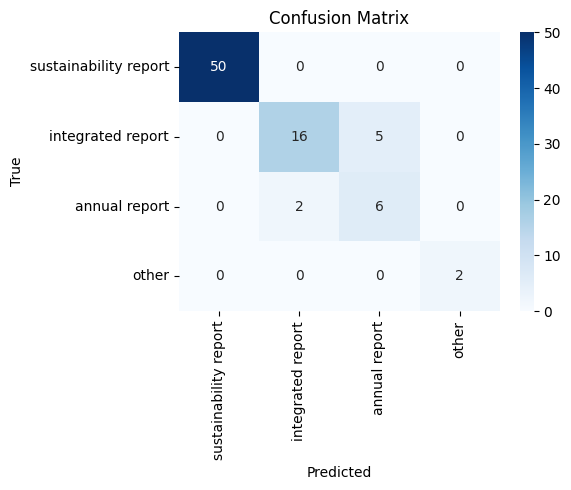

In [ ]:
import pandas as pd

# ==== 1. 设置文件路径 ====
# 修改为你本地的绝对路径或相对路径
human_label_path = "check/pdf_classification.xlsx"
gpt_result_path = "results/pipeline7-gpt.csv"

# ==== 2. 读取文件 ====
df_human = pd.read_excel(human_label_path)
df_gpt = pd.read_csv(gpt_result_path)

# ==== 3. 标准化列名，确保 filename 和 report_type 存在 ====
df_human.columns = [col.strip().lower() for col in df_human.columns]
df_gpt.columns = [col.strip().lower() for col in df_gpt.columns]

# ==== 4. 合并两个表 ====
df_merged = pd.merge(df_human, df_gpt, left_on="file_name",
    right_on="filename",
    how="left")
df_merged = df_merged.drop_duplicates(subset="file_name", keep="first")

# ==== 6. 比较两个分类结果 ====
df_merged["report_type_human"] = df_merged["report_type_human"].str.strip().str.lower()
df_merged["report_type_gpt"] = df_merged["report_type"].str.strip().str.lower()
df_merged["is_correct"] = df_merged["report_type_human"] == df_merged["report_type_gpt"]

# ==== 7. 计算准确率 ====
accuracy = df_merged["is_correct"].mean()
print(f"accuracy: {accuracy:.2%}")

# ==== 8. 导出对比结果（可选）====
import re

def clean_illegal_excel_chars(text):
    if isinstance(text, str):
        return re.sub(r"[\x00-\x1F\x7F]", "", text)
    return text

# 清理非法字符
df_merged_cleaned = df_merged.applymap(clean_illegal_excel_chars)

# 再导出
# df_merged_cleaned.to_excel("pipeline_eval/7/classification_comparison.xlsx", index=False)
print("✅ Saved to classification_comparison.xlsx")
# df_merged.to_excel("pipeline_eval/7/classification_comparison.xlsx", index=False)
# print("saved to classification_comparison_result.xlsx")

import sklearn
from sklearn.metrics import classification_report, confusion_matrix

# === 仅保留非空对比项（防止空值影响）===
valid = df_merged[~df_merged["report_type_human"].isna() & ~df_merged["report_type_gpt"].isna()]

# === 打印 classification report ===
report = classification_report(
    valid["report_type_human"], 
    valid["report_type_gpt"], 
    digits=3, 
    output_dict=False  # 改为 True 可返回字典
)
print("📊 detailed \n")
print(report)

# === 可视化混淆矩阵（可选）===
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(valid["report_type_human"], valid["report_type_gpt"], labels=valid["report_type_human"].unique())
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=valid["report_type_human"].unique(),
            yticklabels=valid["report_type_human"].unique())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from difflib import SequenceMatcher
import re
import ast

# === Step 1: 加载文件 ===
df_pred = pd.read_csv("results/pipeline7-gpt.csv")              # 需包含: filename, company_name, other_names
df_true = pd.read_csv("check/matching_gabarito_with_pdfs2.csv")  # 需包含: pdf_path, name_2

# 统一/去空
df_pred["filename"] = df_pred["filename"].astype(str).str.strip()
df_true["filename"] = df_true["pdf_path"].astype(str).str.strip()
df_pred["company_name"] = df_pred["company_name"].astype(str)  # 防止 NaN -> float
df_pred["other_names"] = df_pred.get("other_names", "").fillna("").astype(str)
df_true["name_2"] = df_true["name_2"].astype(str)

df_merged = pd.merge(df_pred, df_true, on="filename", how="inner")

# === Step 2: 工具函数 ===
SUFFIXES = [
    " company"," companies"," corporation"," incorporated"," corp"," llc"," ltd"," inc",
    " oyj"," intl"," sa"," lp"," spa"," sanv"," nv"," plc"," nvsa"," ptd",
    " int"," international","limited","group"," holdings"," co"
]
STOPWORDS = {"group","holdings","company","limited","corporation","inc","co","plc","corp","ltd","llc","sa","nv","oyj","spa","intl","int"}

def safe_str(x):
    return "" if x is None or (isinstance(x, float) and pd.isna(x)) else str(x)

def _clean_name(name: str) -> str:
    s = safe_str(name).lower()
    s = re.sub(r"\([^()]*\)", "", s)           # 去括号内容
    s = re.sub(r"[^\w\d\s]", "", s)            # 去标点
    for suf in SUFFIXES:
        s = s.replace(suf, "")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def fuzzy_ratio(a, b):
    return SequenceMatcher(None, _clean_name(a), _clean_name(b)).ratio()

def split_other_names(raw):
    text = safe_str(raw).strip()
    if not text:
        return []
    # JSON 列表字符串
    if text.startswith("["):
        try:
            lst = ast.literal_eval(text)
            return [safe_str(x).strip() for x in lst if safe_str(x).strip()]
        except Exception:
            pass
    # 常见分隔符
    parts = re.split(r"[;,\n|/]+", text)
    return [p.strip() for p in parts if p.strip()]

def word_overlap(a, b):
    wa = {w for w in re.findall(r"\b\w+\b", safe_str(a).lower()) if w not in STOPWORDS and len(w) > 2}
    wb = {w for w in re.findall(r"\b\w+\b", safe_str(b).lower()) if w not in STOPWORDS and len(w) > 2}
    return len(wa & wb) > 0

def substr_match(a, b):
    aa = _clean_name(a).replace(" ", "")
    bb = _clean_name(b).replace(" ", "")
    return (aa and bb) and (aa in bb or bb in aa)

def acronym(name):
    words = [w for w in re.findall(r"\b\w+\b", safe_str(name).upper()) if w.lower() not in STOPWORDS and len(w) > 2]
    return "".join(w[0] for w in words)

def acronym_match(a, b):
    ac = acronym(a)
    bc = acronym(b)
    return bool(ac) and ac == bc

# === Step 3: 主匹配逻辑（主名/别名 + 多重兜底）===
STRICT = 0.85  # 严格阈值：fuzzy >= 0.85

def get_best_match(row):
    name_true = safe_str(row["name_2"])
    name_main = safe_str(row["company_name"])
    best_score = fuzzy_ratio(name_main, name_true)
    matched_by = "company_name" if best_score >= STRICT else "no_match"

    # 先试别名（取最高分）
    cand_alias = split_other_names(row.get("other_names", ""))
    for alias in cand_alias:
        score = fuzzy_ratio(alias, name_true)
        if score > best_score:
            best_score = score
            matched_by = f"other_names({alias})" if score >= STRICT else "no_match"

    is_correct = best_score >= STRICT

    # === 兜底：若严格没过阈值，尝试 词交集 / 子串 / 缩写 ===
    if not is_correct:
        if word_overlap(name_main, name_true):
            is_correct = True
            matched_by = "fallback_word_overlap"
        elif any(word_overlap(a, name_true) for a in cand_alias):
            is_correct = True
            matched_by = "fallback_word_overlap_from_alias"
        elif substr_match(name_main, name_true) or any(substr_match(a, name_true) for a in cand_alias):
            is_correct = True
            matched_by = "fallback_substring"
        elif acronym_match(name_main, name_true) or any(acronym_match(a, name_true) for a in cand_alias):
            is_correct = True
            matched_by = "fallback_acronym"

    return pd.Series({
        "fuzzy_score": best_score,
        "is_correct": bool(is_correct),
        "matched_by": matched_by
    })

# === Step 4: 应用匹配函数 ===
df_merged[["fuzzy_score", "is_correct", "matched_by"]] = df_merged.apply(get_best_match, axis=1)

# === Step 5: 输出评估表 & 准确率 ===
df_eval = df_merged[["filename", "company_name", "other_names", "name_2", "fuzzy_score", "is_correct", "matched_by"]]
# df_eval.to_csv("pipeline_eval/7/company_name2.csv", index=False)

accuracy = df_eval["is_correct"].mean()
print(f"✅ Company name extraction accuracy (alias + fallbacks): {accuracy:.2%}")
print("📄 Saved:", "eval/company_name_eval_with_alias_and_fallback.csv")

✅ Company name extraction accuracy (alias + fallbacks): 98.04%
📄 Saved: eval/company_name_eval_with_alias_and_fallback.csv


In [15]:
import pandas as pd
import re, ast
from name_matching.name_matcher import NameMatcher

# ===== 1) 读取与对齐 =====
pred = pd.read_csv("results/pipeline_with_tokens-mini.csv")                # 需包含: filename, company_name, other_names(可无/可为空)
true = pd.read_csv("check/matching_gabarito_with_pdfs2.csv")  # 需包含: pdf_path, name_2

pred["filename"] = pred["filename"].astype(str).str.strip()
true["filename"] = true["pdf_path"].astype(str).str.strip()

df = pred.merge(true, on="filename", how="inner")

# ===== 2) 构造主库（老师给的标准名） =====
master = (
    df[["name_2"]]
    .dropna()
    .drop_duplicates()
    .rename(columns={"name_2": "Company name"})
    .reset_index(drop=True)
)

# ===== 3) 展开候选（company_name + other_names）=====
def split_other_names(raw):
    """支持 JSON 列表字符串 或 分号/逗号/换行/竖线/斜杠 分隔"""
    if pd.isna(raw): 
        return []
    s = str(raw).strip()
    if not s:
        return []
    if s.startswith("["):
        try:
            lst = ast.literal_eval(s)
            return [x.strip() for x in lst if isinstance(x, str) and x.strip()]
        except Exception:
            pass
    parts = re.split(r"[;,\n|/]+", s)
    return [p.strip() for p in parts if p.strip()]

rows = []
for _, r in df.iterrows():
    cands = [str(r.get("company_name", "")).strip()]
    cands += split_other_names(r.get("other_names", ""))
    for c in cands:
        if c:
            rows.append({"filename": r["filename"], "candidate": c})
cand_df = pd.DataFrame(rows).drop_duplicates()

# 如果某些文件没有任何候选，补个空占位（避免后面 join 丢失）
if cand_df.empty:
    raise ValueError("No candidates found. Check columns: company_name / other_names.")

# ===== 4) 初始化 name_matching 并加载主库 =====
matcher = NameMatcher(
    number_of_matches=1,   # 每个候选只取一个最优命中
    legal_suffixes=True,   # 自动处理 Inc/LLC/Group 等后缀
    common_words=False,    # 常见词不过滤（你也可以改 True 试试）
    top_n=50,              # 候选池大小
    verbose=False
)

# 可以组合多种距离度量；推荐先试下面这组（来自官方示例）
matcher.set_distance_metrics(['bag', 'typo', 'refined_soundex'])

matcher.load_and_process_master_data(
    column='Company name',
    df_matching_data=master,
    transform=True
)

# ===== 5) 执行匹配 =====
matches = matcher.match_names(
    to_be_matched=cand_df,
    column_matching='candidate'
)
# matches 包含：match_name（命中的 name_2）、match_index、score(0-100)

cand_scored = cand_df.join(matches)

# ===== 6) 选“每个文件”的最好命中（分数最高）=====
best_per_file = (
    cand_scored
    .sort_values(["filename", "score"], ascending=[True, False])
    .drop_duplicates("filename")
    .rename(columns={"match_name": "matched_name_2", "score": "nm_score"})
)

# ===== 7) 合并回原始 df，评估 =====
eval_df = df.merge(best_per_file[["filename", "candidate", "matched_name_2", "nm_score"]],
                   on="filename", how="left")

# 判定是否匹配：严格阈值（可调）
STRICT = 85
eval_df["is_correct"] = (eval_df["nm_score"].fillna(0) >= STRICT)

# 标注匹配来源：主名 or 别名
def matched_by(row):
    cname = str(row.get("company_name", "")).strip()
    cand  = str(row.get("candidate", "")).strip()
    if not cand:
        return "no_match"
    return "company_name" if cand == cname else "other_names"

eval_df["matched_by"] = eval_df.apply(matched_by, axis=1)

# ===== 8) 输出结果 =====
out_cols = [
    "filename", "company_name", "other_names", "name_2",
    "candidate", "matched_name_2", "nm_score", "is_correct", "matched_by"
]
# eval_df[out_cols].to_csv("eval/company_name_eval_name_matching_only.csv", index=False)

acc = eval_df["is_correct"].mean()
print(f"✅ Accuracy (name_matching only, threshold={STRICT}): {acc:.2%}")
print("📄 Saved: eval/company_name_eval_name_matching_only.csv")

✅ Accuracy (name_matching only, threshold=85): 95.10%
📄 Saved: eval/company_name_eval_name_matching_only.csv
